In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import skimage
import importlib
from tqdm import tqdm

from vision_transformer import vit_small
from torchvision.models import resnet18, ResNet18_Weights
from timm import create_model
import torch.nn.functional as F
import sys

import argparse

In [2]:
model = vit_small()
from collections import OrderedDict
model_keys = torch.load("/scr/vidit/Foundation_Models/model_weights/CHAMMIs10d_Global_Normalization/checkpoint.pth")['student']
student_model = torch.load("/scr/vidit/Foundation_Models/model_weights/checkpoint0080.pth")['student']
remove_prefixes = ["module.backbone.", "module.", "module.head."]
exclude_keys = ["head.mlp", "head.last_layer"]  # Remove classification head
cleaned_state_dict = OrderedDict()

type(student_model)

/tmp/ipykernel_3464188/4262294972.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_keys = torch.load("/scr/vidit/Foundation_Models/model_weights/CHAMMIs10d_Global_N

collections.OrderedDict

/tmp/ipykernel_3222682/31031515.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


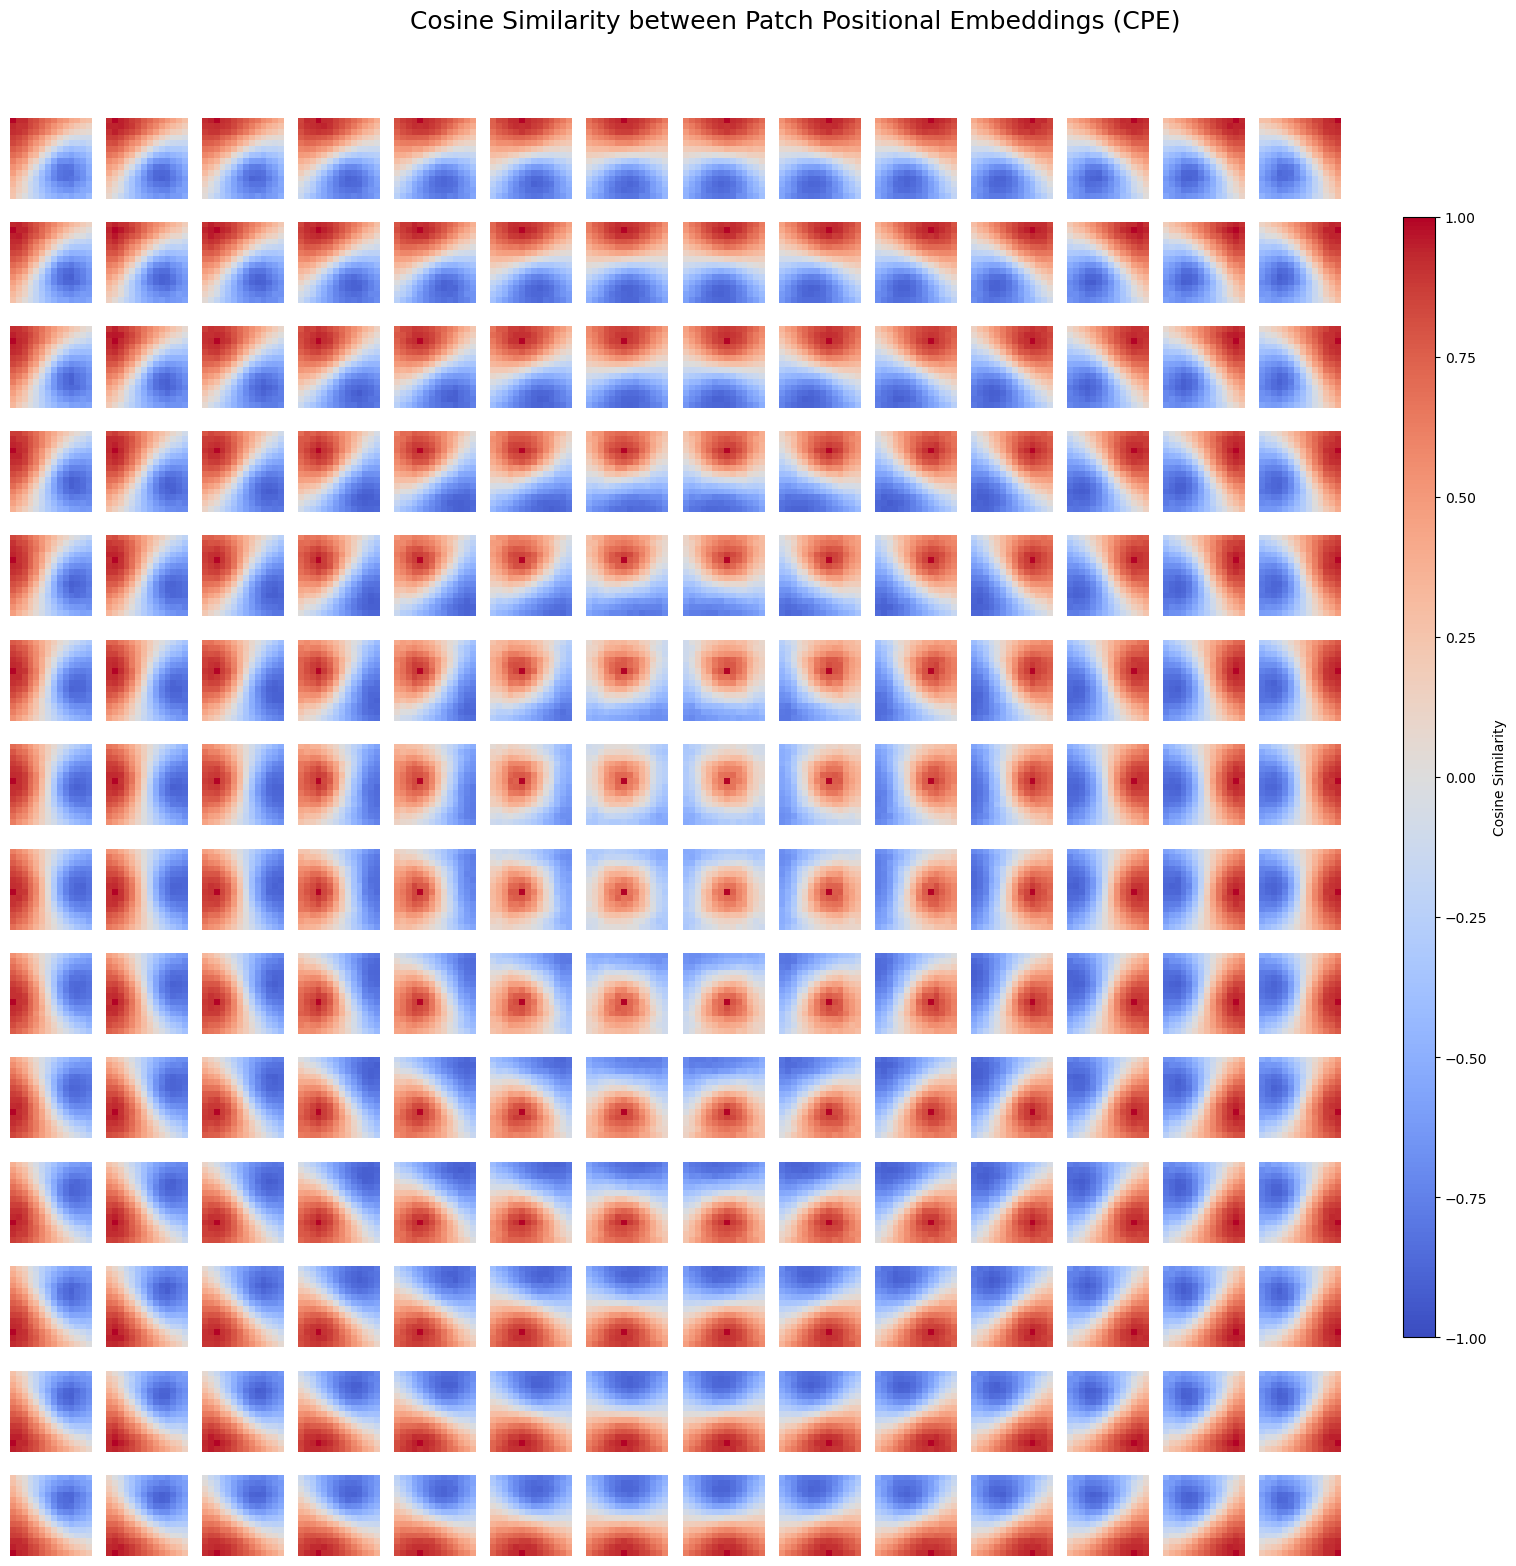

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

pos_embed = model_keys["module.backbone.pos_embed"].squeeze(0)
patch_pos_embed = pos_embed[1:]

cos_sim_matrix = cosine_similarity(patch_pos_embed.cpu().numpy())  # [196 x 196]

# Define grid size for ViT/16 (224x224 images → 14x14 patches)
grid_size = 14

# Create the full grid of heatmaps
fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16), 
                         sharex=True, sharey=True)

for idx in range(grid_size * grid_size):
    ax = axes[idx // grid_size, idx % grid_size]
    sim = cos_sim_matrix[idx].reshape(grid_size, grid_size)
    ax.imshow(sim, vmin=-1, vmax=1, cmap='coolwarm')
    ax.axis('off')

# Add a single colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=- 1, vmax=1)), cax=cbar_ax)
cbar.set_label('Cosine Similarity')

plt.suptitle("Cosine Similarity between Patch Positional Embeddings (NON-CPE)", fontsize=18)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()

In [ ]:
# Remove unwanted prefixes
cleaned_state_dict = {}
for k, v in student_model.items():
    new_key = k
    for prefix in remove_prefixes:
        if new_key.startswith(prefix):
            new_key = new_key[len(prefix):]  # Remove prefix
    if not new_key.startswith("head.mlp") and not new_key.startswith("head.last_layer"):
        cleaned_state_dict[new_key] = v  # Keep only valid keys

In [ ]:
import torch
import sys
sys.path.append("/scr/vidit/Foundation_Models/FoundationModels/dinov1")
import vision_transformer as vits
from vision_transformer import DINOHead



# Choose model size (options: vit_tiny, vit_small, vit_base)
model_name = "vit_small"
patch_size = 16  # Options: 8 or 16

# Instantiate the base ViT model
model = vits.__dict__[model_name](patch_size=patch_size, num_classes=0)

# Load a pretrained checkpoint (replace with your actual path)
pretrained_weights = "/scr/vidit/Foundation_Models/model_weights/CHAMMIs10d_Scaling_Crops_Local/checkpoint.pth"

# Load the weights
if torch.cuda.is_available():
    model = model.cuda()

# Load checkpoint (handles different checkpoint formats)
if "teacher" in torch.load(pretrained_weights, map_location="cpu", weights_only=False):
    # If checkpoint contains teacher model (typical for DINO)
    state_dict = torch.load(pretrained_weights, map_location="cpu", weights_only=False)["teacher"]
    # Remove prefix if needed
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
else:
    # Direct state dict
    state_dict = torch.load(pretrained_weights, map_location="cpu")
    msg = model.load_state_dict(state_dict, strict=False)

print(f"Loaded pretrained weights from {pretrained_weights} with message: {msg}")

# Set to evaluation mode
model.eval()

# Function to extract features from an image
def extract_features(img_tensor):
    with torch.no_grad():
        if torch.cuda.is_available():
            img_tensor = img_tensor.cuda()
        # Get features (output of the model before classification head)
        features = model(img_tensor)
        return features


/tmp/ipykernel_3464188/979911654.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if "teacher" in torch.load(pretrained_weights, map_location="cpu"):
/tmp/ipykernel_3464

Loaded pretrained weights from /scr/vidit/Foundation_Models/model_weights/CHAMMIs10d_Scaling_Crops_Local/checkpoint.pth with message: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [ ]:
import torch
from models_mae import mae_vit_base_patch16
state_dict = torch.load("/scr/vidit/Foundation_Models/model_weights/MAE_CHAMMI_Train/checkpoint-399.pth", map_location="cpu")
print(state_dict['model'].keys())
model = mae_vit_base_patch16()
model.load_state_dict(state_dict['model'], strict=False)
model.patch_embed.proj.kernel_size

/tmp/ipykernel_3933832/2936760262.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/scr/vidit/Foundation_Models/model_weights/MAE_CHAMMI_Train/ch